In [2]:
# Imports
import random
import scipy
import scipy.io
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
% matplotlib inline

In [3]:
class DataLoader:
    """
    Class for loading the MatLab data.
    """

    def __init__(self, file):
        """
        Load the data from the given file.

        :param file: Path to file to load the data from (without the .mat extension).
        :param flip_rate: Rate for flipping bits randomly, 0 means no flipping and 1 means all flipped and the
                          maximum entropy is obtained for flip_rate = 0.5.
        """
        self.data = scipy.io.loadmat(file, squeeze_me=True, struct_as_record=False)['mnist']
        self.train_images = self.data.train_images
        self.test_images = self.data.test_images
        self.train_labels = self.data.train_labels
        self.test_labels = self.data.test_labels

    def load_images(self, flip_rate=0):
        self.train_images = self.transform_images(self.train_images)
        self.test_images = self.transform_images(self.test_images)
        if flip_rate > 0:
            noise = np.random.binomial(1, flip_rate, self.train_images.shape) * -2 + 1
            self.train_images = np.multiply(self.train_images, noise)

    def transform_images(self, data):
        """
        Convert a (m x n x p) array to a (p x m x n) array and apply some additional transformations.

        :param data: Data to transform.
        :return: Transformed data.
        """
        reshaped = data.reshape(data.shape[0] * data.shape[1], data.shape[2])
        swapped_axes = np.swapaxes(reshaped, 0, 1)
        return (swapped_axes > 122) * 2 - 1

In [4]:
num_neurons = 28 * 28
learning_rate = 0.01
w = np.random.normal(0, 1, (num_neurons, num_neurons))
theta = np.random.normal(0, 1, (num_neurons,))
np.fill_diagonal(w, 1)

In [5]:
data = DataLoader('mnistAll')
data.load_images(0.1)

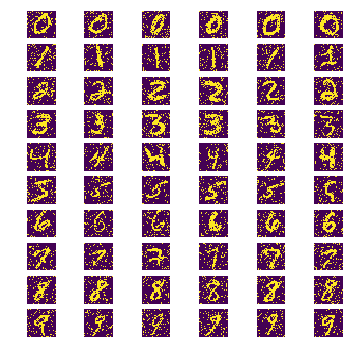

In [6]:
f, ax = plt.subplots(10, 6, figsize=(6, 6))

for digit in range(0, 10):
    samples = data.train_images[data.train_labels == digit]
    for sample in range(0, 6):
        ax[digit][sample].imshow(samples[sample, :].reshape(28, 28))
        ax[digit][sample].axis('off')

In [7]:
def calculate_probabilities(samples, w, theta, normalizing_constant):
    return np.exp(-calculate_energy(samples, w, theta)) / normalizing_constant

def calculate_energy(samples, w, theta):
    f = np.dot(samples, np.dot(w, samples.T))
    # Also allow samples consisting of one sample (an array, so f.ndim == 1)
    # Therefore, only take the diagonal in the two dimensional case
    if f.ndim == 2:
        f = np.diagonal(f)
    return np.squeeze(np.asarray(-0.5 * f - np.dot(theta.T, samples.T)))

In [ ]:
training_samples = data.train_images[data.train_labels == 2]

In [12]:
def train_classifiers(samples, labels):
    w = np.zeros((10, 28 * 28, 28 * 28))
    theta = np.zeros((10, 28 * 28))
    Z = np.zeros(10)
    for digit in range(0, 10):
        training_samples = samples[labels == digit]
        s_mean_clamped = np.squeeze(np.asarray(np.mean(training_samples, 0)))
        s_cov_clamped = np.cov(training_samples.T)
        m = s_mean_clamped
        C = s_cov_clamped - np.dot(np.asmatrix(s_mean_clamped).T, np.asmatrix(s_mean_clamped))
        delta = np.zeros(s_cov_clamped.shape)
        np.fill_diagonal(delta, 1. / (1. - np.multiply(m, m)))
        w[digit, :, :] = delta - np.linalg.inv(C)
        theta[digit, :] = np.arctanh(m) - np.dot(w[digit, :, :], m)
        F = -0.5 * np.dot(np.dot(m, w[digit, :, :]), m) - np.dot(theta[digit, :], m) + 0.5 * np.dot(1 + m, np.log(0.5 * (1 + m))) + 0.5 * np.dot(1 - m, np.log(0.5 * (1 - m)))
        Z[digit] = np.exp(-F)
    return w, theta, Z

In [13]:
data = DataLoader('mnistAll')
data.load_images(0.1)
w, theta, Z = train_classifiers(data.train_images, data.train_labels)

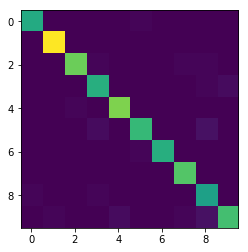

In [14]:
X = data.test_images

num_samples = 500
probabilities = np.zeros((10, num_samples))
for digit in range(0, 10):
    probabilities[digit, :] = calculate_probabilities(X[:num_samples, :], w[digit, :, :], theta[digit, :], Z[digit])
    
predicted = np.argmax(probabilities, axis=0)
real = data.test_labels[:num_samples]

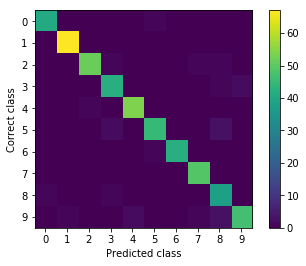

23


In [21]:
cm = confusion_matrix(real, predicted)
plt.imshow(cm)
plt.xticks(np.arange(0, 10, 1))
plt.yticks(np.arange(0, 10, 1))
plt.xlabel('Predicted class')
plt.ylabel('Correct class')
plt.colorbar()
plt.show()

print(np.sum(real != predicted))

In [9]:
metrics.accuracy_score(real, predicted)

0.95599999999999996

In [16]:
cm.diagonal() / cm.sum(axis=1)

array([ 0.97619048,  1.        ,  0.94545455,  0.93333333,  0.98181818,
        0.9       ,  0.97674419,  1.        ,  0.95      ,  0.85185185])

# Research question
Which noise level yields the lowest accuracy?

In [12]:
noise_levels = np.arange(0.01, 0.51, 0.01)
#accuracy = []

X = data.test_images
rounds = 10
num_samples = 500
#accuracy = np.zeros((len(noise_levels), rounds))
#for k in range(rounds):
k = 9
for noise_index, noise_level in enumerate(noise_levels):
    perm = np.random.permutation(X.shape[0])
    data = DataLoader('mnistAll')
    data.load_images(noise_level)
    w, theta, Z = train_classifiers(data.train_images, data.train_labels)

    probabilities = np.zeros((10, num_samples))
    for digit in range(0, 10):
        probabilities[digit, :] = calculate_probabilities(X[perm[:num_samples], :], w[digit, :, :], theta[digit, :], Z[digit])

    predicted = np.argmax(probabilities, axis=0)
    real = data.test_labels[perm[:num_samples]]

    accuracy[noise_index, k] = metrics.accuracy_score(real, predicted)
    print(k, noise_level, accuracy[noise_index, k])

9 0.25 0.94
9 0.26 0.944
9 0.27 0.944
9 0.28 0.932
9 0.29 0.93
9 0.3 0.932
9 0.31 0.948
9 0.32 0.946
9 0.33 0.946
9 0.34 0.942
9 0.35 0.936
9 0.36 0.922
9 0.37 0.918
9 0.38 0.922
9 0.39 0.9
9 0.4 0.902
9 0.41 0.886
9 0.42 0.896
9 0.43 0.908
9 0.44 0.85
9 0.45 0.848
9 0.46 0.85
9 0.47 0.798


/home/kevin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


9 0.48 0.102
9 0.49 0.004
9 0.5 0.148


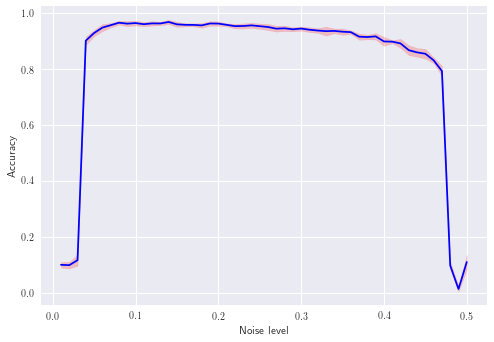

In [36]:
import pickle
import seaborn as sns
with open('acc.pickle', 'rb') as file:
    acc = pickle.load(file)
noise_levels = np.arange(0.01, 0.51, 0.01)
accuracy = acc[:, :9]
mean_accuracy = np.mean(accuracy, axis=1)
plt.plot(noise_levels, mean_accuracy, '-b')
error = np.std(accuracy, axis=1)
plt.fill_between(noise_levels, mean_accuracy - error, mean_accuracy + error, alpha=0.2, edgecolor='#FF0000', facecolor='#FF0000')
plt.rc('text', usetex=True)
plt.ylabel('Accuracy')
plt.xlabel('Noise level')

In [248]:
print(np.mean(accuracy, axis=1))

[ 0.9326  0.9622  0.9604  0.9588  0.9516  0.9388  0.9332  0.904   0.8494
  0.117 ]


In [17]:
def generate_samples(s, w, theta, num_burn_in=50, num_samples=500, show_transition_probabilities=False):
    num_neurons = w.shape[0]
    
    # Initialize the matrix of generated samples
    X = np.empty((0, num_neurons))
    
    # Iterate (first generate some samples during the burn-in period and then gather the samples)
    for iteration in range(num_samples):
        for burn_in in range(num_burn_in + 1):
            # Store the original value of s
            s_original = s
            # Calculate the flip probabilities
            p_flip = 0.5 * (1 + np.tanh(np.multiply(-s, np.dot(w, s) + theta)))
            # Calculate transition probabilities
            p_transition = p_flip / float(num_neurons)
            p_stay = 1 - np.sum(p_transition)
            # Flip according to the probability distribution of flipping
            if random.random() <= 1 - p_stay:
                # Pick a random neuron
                neuron = random.randint(1, num_neurons) - 1
                if random.random() <= p_flip[neuron]:
                    s[neuron] *= -1
            # Add the state if the sample is not generated during the burn in period
            if burn_in >= num_burn_in:
                if show_transition_probabilities:
                    print('Transition probabilities for ', s_original,':', p_transition, ' (stay probability: ', p_stay, ')')
                X = np.vstack([X, s])
    return X

In [18]:
data = DataLoader('mnistAll')
data.load_images(0.1)
w, theta, Z = train_classifiers(data.train_images, data.train_labels)

In [18]:
from IPython import display
import time

digit = 3

#s = theta[digit, :]
#s = s + np.random.normal(0, 0.001, s.shape)
#s[s > 0] = 1
#s[s < 0] = -1
s = np.ones((28 * 28,))
for i in range(1000):
    samples = generate_samples(s, w[digit, :, :], theta[digit, :], 500, 1)
    s = samples[0, :]
    plt.imshow(samples[samples.shape[0] - 1, :].reshape(28, 28))
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.1)

KeyboardInterrupt: 

KeyboardInterrupt: 

In [51]:
data = DataLoader('mnistAll')
data.load_images(0.15)
w, theta, Z = train_classifiers(data.train_images, data.train_labels)

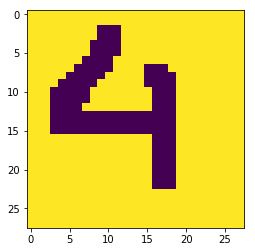

[[  1.46281096e-46]
 [  2.43134205e-70]
 [  2.07763417e-31]
 [  3.42617316e-33]
 [  1.48082430e-53]
 [  1.15014648e-19]
 [  1.06034657e-13]
 [  3.70123537e-75]
 [  6.42791708e-24]
 [  2.06743196e-41]]
Prediction:  [6]


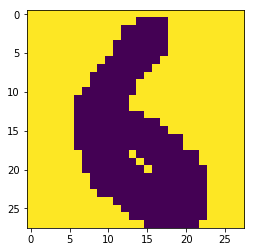

In [120]:
import scipy.misc

img = scipy.misc.imread('6.png')
img = np.dot(img, [0.3, 0.3, 0.3]) / 255.
img[img > 0.5] = 1
img[img < 0.5] = -1
plt.imshow(img)

probabilities = np.zeros((10, 1))
data = img.reshape(1, 28 * 28)
for digit in range(0, 10):
    probabilities[digit, :] = calculate_probabilities(data, w[digit, :, :], theta[digit, :], Z[digit])
print(probabilities)
print('Prediction: ', np.argmax(probabilities, axis=0))

In [78]:
)

(28, 28)
